<a href="https://colab.research.google.com/github/HarshiniBhat/MNIST/blob/main/mnist_param%3C15k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem Statement
Write a network architecture in such a way:

- 99.4% validation accuracy
- Less than 20k Parameters
- Less than 20 Epochs
- Have used BN, Dropout, a Fully connected layer, have used GAP.

# Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np 

# Downloading DataSet


In [ ]:
torch.manual_seed(1)
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
bs = 256

train_set = torch.utils.data.DataLoader(
    datasets.MNIST('../data/', train=True, download=True, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])
    ),
    batch_size=bs, shuffle=True, **kwargs
)

test_set = torch.utils.data.DataLoader(
    datasets.MNIST('../data/', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])
    ),
    batch_size=bs, **kwargs
)

# Data Visualisation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


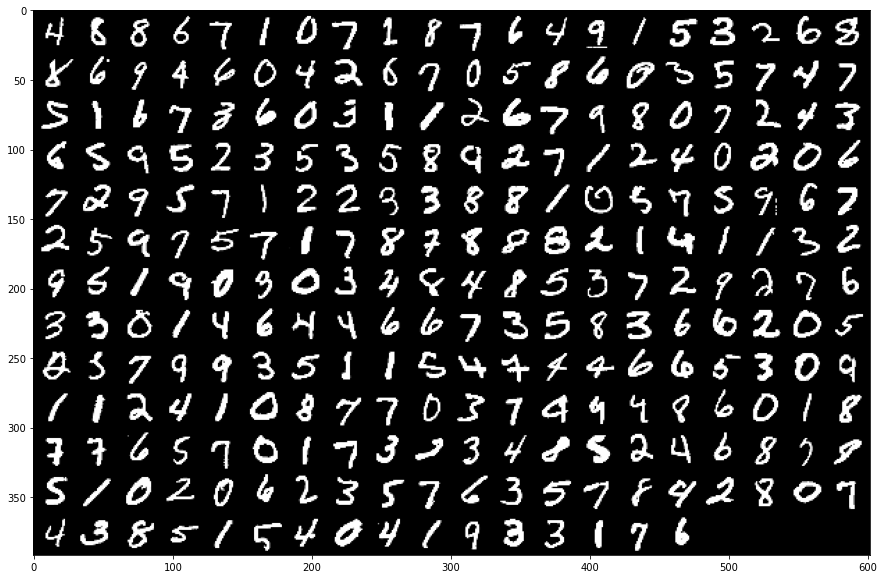

In [ ]:
from torchvision.utils import make_grid # For making the grid
batch = next(iter(train_set))   # Accesing batch
images, labels = batch 

grid = make_grid(images, nrow=20);    # Creating grid of images
plt.figure(figsize=(15,15)); # figure size of 15x15
plt.imshow(np.transpose(grid, (1,2,0)));

# Define Network

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.max_pool = nn.MaxPool2d(2,2)
    drop = 0.05

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(1, 8, 3, padding=1, bias=False),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout2d(drop),

        nn.Conv2d(8, 24, 3, padding=1, bias=False),
        nn.BatchNorm2d(24),
        nn.ReLU(),
        nn.Dropout2d(drop),

        #nn.Conv2d(16, 24, 3, padding=1, bias=False),
        #nn.BatchNorm2d(24),
        #nn.ReLU(),
        #nn.Dropout2d(drop),
    )

    self.transition1 = nn.Sequential(
        nn.Conv2d(24, 8, 1, bias=False),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout2d(drop),
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(8, 16, 3, bias=False),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout2d(drop),

        nn.Conv2d(16, 24, 3, bias=False),
        nn.BatchNorm2d(24),
        nn.ReLU(),
        nn.Dropout2d(drop),
    )

    self.transition2 = nn.Sequential(
        nn.Conv2d(24, 8, 1, bias=False),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout2d(drop),
    )
  
    self.conv_block3 = nn.Sequential(
        nn.Conv2d(8, 16, 3, bias=False),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout2d(drop),

        nn.Conv2d(16, 32, 3, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Dropout2d(drop),
    )

    self.gap = nn.Sequential(
        nn.AvgPool2d(6)
    )
    self.dense = nn.Linear(32, 10)

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.max_pool(x)
    x = self.transition1(x)

    x = self.conv_block2(x)
    x = self.transition2(x)

    x = self.conv_block3(x)
    # x = self.transition3(x)

    x = self.gap(x)
    x = x.view(-1, 32)    
    x = self.dense(x)

    return F.log_softmax(x, dim=1)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28)) # putting the input size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 24, 28, 28]           1,728
       BatchNorm2d-6           [-1, 24, 28, 28]              48
              ReLU-7           [-1, 24, 28, 28]               0
         Dropout2d-8           [-1, 24, 28, 28]               0
         MaxPool2d-9           [-1, 24, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             192
      BatchNorm2d-11            [-1, 8, 14, 14]              16
             ReLU-12            [-1, 8, 14, 14]               0
        Dropout2d-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1, 16,

# Training Network

In [ ]:
def train(model, device, train_loader, optimizer):
    model.train() # training model
    pbar = tqdm(train_loader)
    t_acc = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # optimizer
        output = model(data) # output of the model

        loss = F.nll_loss(output, target) # calculate the loss
        loss.backward() # backpropogation
        optimizer.step() # optimization

        pred = output.argmax(dim=1).eq(target).sum().item() # final prediction
        t_acc += pred # accuracy
        pbar.set_description(desc= f'loss={loss.item():.4f} batch_id={batch_idx}') # setting the output
    
    return loss.item(), t_acc / len(train_loader.dataset)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data) # output of the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    # printing the loss and accuracy of test
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, correct/len(test_loader.dataset)

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.5, momentum=0.9) # SGD optimizer
num_epoch = 20 # number of epochs

# defining the dictionary for train and test, loss and accuracy
h = dict() 
h['train_loss'] = list()
h['train_accuracy'] = list()
h['test_loss'] = list()
h['test_accuracy'] = list()


for epoch in range(1, num_epoch+1):
    print(epoch)
    train_loss, train_acc = train(model, device, train_set, optimizer) # calling the training
    test_loss, test_acc = test(model, device, test_set) # calling the testing

    h['train_loss'].append(train_loss) # storing the training loss
    h['train_accuracy'].append(train_acc) # storing  the accuracy

    h['test_loss'].append(test_loss) # storing the testing loss
    h['test_accuracy'].append(test_acc) # storing the testing accuracy

1


loss=0.0581 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.82it/s]


Test set: Average loss: 0.0591, Accuracy: 9808/10000 (98.08%)

2


loss=0.1088 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.10it/s]


Test set: Average loss: 0.0449, Accuracy: 9856/10000 (98.56%)

3


loss=0.0362 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.04it/s]


Test set: Average loss: 0.0372, Accuracy: 9881/10000 (98.81%)

4


loss=0.0141 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.10it/s]


Test set: Average loss: 0.0359, Accuracy: 9876/10000 (98.76%)

5


loss=0.1281 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.16it/s]


Test set: Average loss: 0.0294, Accuracy: 9903/10000 (99.03%)

6


loss=0.0702 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.22it/s]


Test set: Average loss: 0.0288, Accuracy: 9904/10000 (99.04%)

7


loss=0.0451 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.10it/s]


Test set: Average loss: 0.0280, Accuracy: 9919/10000 (99.19%)

8


loss=0.1499 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.16it/s]


Test set: Average loss: 0.0250, Accuracy: 9919/10000 (99.19%)

9


loss=0.1475 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.06it/s]


Test set: Average loss: 0.0293, Accuracy: 9911/10000 (99.11%)

10


loss=0.0456 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.04it/s]


Test set: Average loss: 0.0262, Accuracy: 9922/10000 (99.22%)

11


loss=0.0475 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.93it/s]


Test set: Average loss: 0.0220, Accuracy: 9926/10000 (99.26%)

12


loss=0.0993 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.11it/s]


Test set: Average loss: 0.0205, Accuracy: 9933/10000 (99.33%)

13


loss=0.0213 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.10it/s]


Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)

14


loss=0.0078 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.99it/s]


Test set: Average loss: 0.0216, Accuracy: 9929/10000 (99.29%)

15


loss=0.0086 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.09it/s]


Test set: Average loss: 0.0239, Accuracy: 9925/10000 (99.25%)

16


loss=0.0287 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.94it/s]


Test set: Average loss: 0.0186, Accuracy: 9941/10000 (99.41%)

17


loss=0.0397 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.96it/s]


Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

18


loss=0.1284 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.96it/s]


Test set: Average loss: 0.0223, Accuracy: 9929/10000 (99.29%)

19


loss=0.0112 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.90it/s]


Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)

20


loss=0.0123 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.00it/s]


Test set: Average loss: 0.0191, Accuracy: 9934/10000 (99.34%)



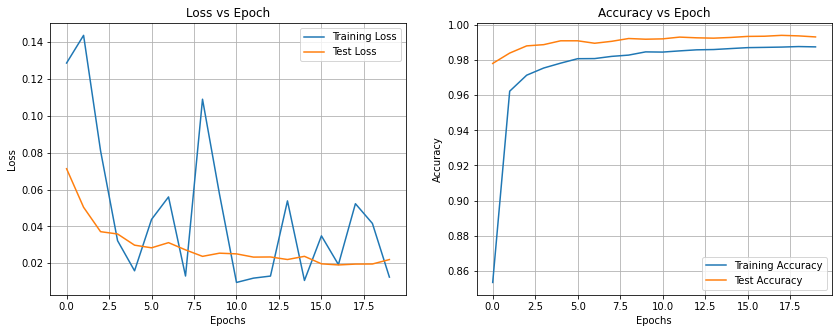

In [ ]:
# For loss and epochs
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(h['train_loss'], label='Training Loss') # plotting the training loss
plt.plot(h['test_loss'], label='Test Loss') # plotting the testing loss
# putting the labels on plot
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

# For accuracy and epochs
plt.subplot(1,2,2)
plt.plot(h['train_accuracy'], label='Training Accuracy') # plotting the training accuracy
plt.plot(h['test_accuracy'], label='Test Accuracy') # plotting the testing accuracy
# putting the labels in plot
plt.title('Accuracy vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.show()

# Assignment:

Your new target is:

- 99.4% (this must be consistently shown in your last few epochs, and not a one-time achievement)
- Less than or equal to 20 Epochs
- Less than 15000 Parameters